### Analysis of motifs using Motif Miner (RINGS tool that employs alpha frequent subtree mining)

In [194]:
csv_files = ["ABA_14361_100ug_v5.0_DATA.csv",
             "ConA_13799-10ug_V5.0_DATA.csv",
             'PNA_14030_10ug_v5.0_DATA.csv',
             "RCAI_10ug_14110_v5.0_DATA.csv",
             "PHA-E-10ug_13853_V5.0_DATA.csv",
             "PHA-L-10ug_13856_V5.0_DATA.csv",
             "LCA_10ug_13934_v5.0_DATA.csv",
             "SNA_10ug_13631_v5.0_DATA.csv",
             "MAL-I_10ug_13883_v5.0_DATA.csv",
             "MAL_II_10ug_13886_v5.0_DATA.csv",
             "GSL-I-B4_10ug_13920_v5.0_DATA.csv",
             "jacalin-1ug_14301_v5.0_DATA.csv",
             'WGA_14057_1ug_v5.0_DATA.csv',
             "UEAI_100ug_13806_v5.0_DATA.csv",
             "SBA_14042_10ug_v5.0_DATA.csv",
             "DBA_100ug_13897_v5.0_DATA.csv",
             "PSA_14040_10ug_v5.0_DATA.csv",
             "HA_PuertoRico_8_34_13829_v5_DATA.csv",
             'H3N8-HA_16686_v5.1_DATA.csv',
             "Human-DC-Sign-tetramer_15320_v5.0_DATA.csv"]

csv_file_normal_names = [
     r"\textit{Agaricus bisporus} agglutinin (ABA)",
     r"Concanavalin A (Con A)",
     r'Peanut agglutinin (PNA)',
     r"\textit{Ricinus communis} agglutinin I (RCA I/RCA\textsubscript{120})",
     r"\textit{Phaseolus vulgaris} erythroagglutinin (PHA-E)",
     r"\textit{Phaseolus vulgaris} leucoagglutinin (PHA-L)",
     r"\textit{Lens culinaris} agglutinin (LCA)",
     r"\textit{Sambucus nigra} agglutinin (SNA)",
     r"\textit{Maackia amurensis} lectin I (MAL-I)",
     r"\textit{Maackia amurensis} lectin II (MAL-II)",
     r"\textit{Griffonia simplicifolia} Lectin I isolectin B\textsubscript{4} (GSL I-B\textsubscript{4})",
     r"Jacalin",
     r'Wheat germ agglutinin (WGA)',
     r"\textit{Ulex europaeus} agglutinin I (UEA I)",
     r"Soybean agglutinin (SBA)",
     r"\textit{Dolichos biflorus} agglutinin (DBA)",
     r"\textit{Pisum sativum} agglutinin (PSA)",
     r"Influenza hemagglutinin (HA) (A/Puerto Rico/8/34) (H1N1)",
     r'Influenza HA (A/harbor seal/Massachusetts/1/2011) (H3N8)',
     r"Human DC-SIGN tetramer"]

In [36]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import interp

sys.path.append('..')

from ccarl.glycan_parsers.conversions import kcf_to_digraph, cfg_to_kcf
from ccarl.glycan_plotting import draw_glycan_diagram
from ccarl.glycan_graph_methods import generate_digraph_from_glycan_string
from ccarl.glycan_features import generate_features_from_subtrees
import ccarl.glycan_plotting

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_curve, auc

import matplotlib.pyplot as plt

In [138]:
from collections import defaultdict

aucs = defaultdict(list)
ys = defaultdict(list)
probs = defaultdict(list)
motifs = defaultdict(list)


for fold in [1,2,3,4,5]:
    print(f"Running fold {fold}...")
    for csv_file in csv_files:
        alpha = 0.8
        minsup = 0.2
        input_file = f'./temp_{csv_file}'
        training_data = pd.read_csv(f"../Data/CV_Folds/fold_{fold}/training_set_{csv_file}")
        test_data = pd.read_csv(f"../Data/CV_Folds/fold_{fold}/test_set_{csv_file}")
        pos_glycan_set = training_data['glycan'][training_data.binding == 1].values
        kcf_string = '\n'.join([cfg_to_kcf(x) for x in pos_glycan_set])
        with open(input_file, 'w') as f:
            f.write(kcf_string)
        min_sup = int(len(pos_glycan_set) * minsup)
        subtrees = os.popen(f"ruby Miner_cmd.rb {min_sup} {alpha} {input_file}").read()
        subtree_graphs = [kcf_to_digraph(x) for x in subtrees.split("///")[0:-1]]
        motifs[csv_file].append(subtree_graphs)

        os.remove(input_file)

        binding_class = training_data.binding.values
        glycan_graphs = [generate_digraph_from_glycan_string(x, parse_linker=True,
                                                             format='CFG')
                              for x in training_data.glycan]

        glycan_graphs_test = [generate_digraph_from_glycan_string(x, parse_linker=True,
                                                                 format='CFG')
                              for x in test_data.glycan]

        features = [generate_features_from_subtrees(subtree_graphs, glycan) for 
                    glycan in glycan_graphs]

        features_test = [generate_features_from_subtrees(subtree_graphs, glycan) for 
                         glycan in glycan_graphs_test]

        logistic_clf = LogisticRegression(penalty='l2', C=100, solver='lbfgs',
                                                  class_weight='balanced', max_iter=1000)

        X = features
        y = binding_class
        logistic_clf.fit(X, y)

        y_test = test_data.binding.values
        X_test = features_test
        fpr, tpr, _ = roc_curve(y_test, logistic_clf.predict_proba(X_test)[:,1], drop_intermediate=False)
        aucs[csv_file].append(auc(fpr, tpr))
        ys[csv_file].append(y_test)
        probs[csv_file].append(logistic_clf.predict_proba(X_test)[:,1])

Running fold 1...
Running fold 2...
Running fold 3...
Running fold 4...
Running fold 5...


In [19]:
# Assess the number of subtrees generated for each CV round.

subtree_lengths = defaultdict(list)

for fold in [1,2,3,4,5]:
    print(f"Running fold {fold}...")
    for csv_file in csv_files:
        alpha = 0.8
        minsup = 0.2
        input_file = f'./temp_{csv_file}'
        training_data = pd.read_csv(f"../Data/CV_Folds/fold_{fold}/training_set_{csv_file}")
        test_data = pd.read_csv(f"../Data/CV_Folds/fold_{fold}/test_set_{csv_file}")
        pos_glycan_set = training_data['glycan'][training_data.binding == 1].values
        kcf_string = '\n'.join([cfg_to_kcf(x) for x in pos_glycan_set])
        with open(input_file, 'w') as f:
            f.write(kcf_string)
        min_sup = int(len(pos_glycan_set) * minsup)
        subtrees = os.popen(f"ruby Miner_cmd.rb {min_sup} {alpha} {input_file}").read()
        subtree_graphs = [kcf_to_digraph(x) for x in subtrees.split("///")[0:-1]]
        subtree_lengths[csv_file].append(len(subtree_graphs))
        os.remove(input_file)

Running fold 1...
Running fold 2...
Running fold 3...
Running fold 4...
Running fold 5...


In [20]:
subtree_lengths = [y for x in subtree_lengths.values() for y in x]
print(np.mean(subtree_lengths))
print(np.max(subtree_lengths))
print(np.min(subtree_lengths))

12.59
24
7


In [39]:
def plot_multiple_roc(data):
    '''Plot multiple ROC curves.
    
    Prints out key AUC values (mean, median etc).
    
    Args:
        data (list): A list containing [y, probs] for each model, where:
            y: True class labels
            probs: Predicted probabilities
    Returns:
        Figure, Axes, Figure, Axes
    '''
    mean_fpr = np.linspace(0, 1, 100)

    fig, axes = plt.subplots(figsize=(4, 4))

    ax = axes
    ax.set_title('')
    #ax.legend(loc="lower right")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_aspect('equal', adjustable='box')
    auc_values = []
    tpr_list = []

    for y, probs in data:
        #data_point = data[csv_file]
        #y = data_point[7] # test binding
        #X = data_point[8] # test features
        #logistic_clf = data_point[0] # model
        fpr, tpr, _ = roc_curve(y, probs, drop_intermediate=False)
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        auc_values.append(auc(fpr, tpr))
        ax.plot(fpr, tpr, color='blue', alpha=0.1, label=f'ROC curve (area = {auc(fpr, tpr): 2.3f})')
        ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))

    mean_tpr = np.mean(tpr_list, axis=0)
    median_tpr = np.median(tpr_list, axis=0)
    upper_tpr = np.percentile(tpr_list, 75, axis=0)
    lower_tpr = np.percentile(tpr_list, 25, axis=0)
    ax.plot(mean_fpr, median_tpr, color='black')

    ax.fill_between(mean_fpr, lower_tpr, upper_tpr, color='grey', alpha=.5,
                     label=r'$\pm$ 1 std. dev.')
    fig.savefig("Motif_Miner_CV_ROC_plot_all_curves.svg")

    fig2, ax2 = plt.subplots(figsize=(4, 4))
    ax2.hist(auc_values, range=[0.5,1], bins=10, rwidth=0.9, color=(0, 114/255, 178/255))
    ax2.set_xlabel("AUC value")
    ax2.set_ylabel("Counts")
    fig2.savefig("Motif_Miner_CV_AUC_histogram.svg")

    print(f"Mean AUC value: {np.mean(auc_values): 1.3f}")

    print(f"Median AUC value: {np.median(auc_values): 1.3f}")
    print(f"IQR of AUC values: {np.percentile(auc_values, 25): 1.3f} - {np.percentile(auc_values, 75): 1.3f}")
    return fig, axes, fig2, ax2, auc_values


Mean AUC value:  0.866
Median AUC value:  0.874
IQR of AUC values:  0.825 -  0.940


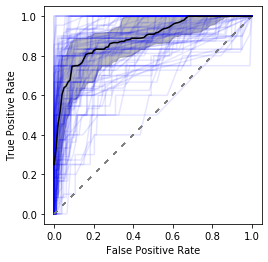

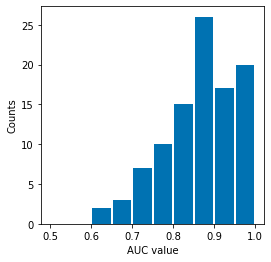

In [40]:
# Plot ROC curves for all test sets
roc_data = [[y, prob] for y_fold, prob_fold in zip(ys.values(), probs.values()) for y, prob in zip(y_fold, prob_fold)]
_, _, _, _, auc_values = plot_multiple_roc(roc_data)

In [45]:
auc_values_ccarl = [0.950268817204301,
 0.9586693548387097,
 0.9559811827956988,
 0.8686155913978494,
 0.9351222826086956,
 0.989010989010989,
 0.9912587412587414,
 0.9090909090909092,
 0.9762626262626264,
 0.9883597883597884,
 0.9065533980582524,
 0.9417475728155339,
 0.8268608414239482,
 0.964349376114082,
 0.9322638146167558,
 0.9178037686809616,
 0.96361273554256,
 0.9362139917695472,
 0.9958847736625515,
 0.9526748971193415,
 0.952300785634119,
 0.9315375982042648,
 0.9705387205387206,
 0.9865319865319865,
 0.9849773242630385,
 0.9862385321100917,
 0.9862385321100918,
 0.9606481481481481,
 0.662037037037037,
 0.7796296296296297,
 0.9068627450980392,
 0.915032679738562,
 0.9820261437908496,
 0.9893790849673203,
 0.9882988298829882,
 0.9814814814814815,
 1.0,
 0.8439153439153441,
 0.9859813084112149,
 0.9953271028037383,
 0.8393308080808081,
 0.8273358585858586,
 0.7954545454545453,
 0.807070707070707,
 0.8966329966329966,
 0.8380952380952381,
 0.6201058201058202,
 0.7179894179894181,
 0.6778846153846154,
 0.75,
 0.9356060606060607,
 0.8619528619528619,
 0.8787878787878789,
 0.9040816326530613,
 0.7551020408163266,
 0.9428694158075602,
 0.9226804123711341,
 0.8711340206185567,
 0.7840909090909091,
 0.8877840909090909,
 0.903225806451613,
 0.8705594120049,
 0.9091465904450796,
 0.8816455696202531,
 0.8521097046413502,
 0.8964521452145213,
 0.9294554455445544,
 0.8271452145214522,
 0.8027272727272727,
 0.8395454545454546,
 0.8729967948717949,
 0.9306891025641025,
 0.9550970873786407,
 0.7934686672550749,
 0.8243601059135041,
 0.8142100617828772,
 0.9179611650485436,
 0.8315533980582525,
 0.7266990291262136,
 0.9038834951456312,
 0.9208916083916084,
 0.7875,
 0.9341346153846154,
 0.9019230769230768,
 0.9086538461538461,
 0.9929245283018868,
 0.9115566037735848,
 0.9952830188679246,
 0.9658018867924528,
 0.7169811320754716,
 0.935981308411215,
 0.9405660377358491,
 0.9905660377358491,
 0.9937106918238994,
 0.9302935010482181,
 0.7564814814814815,
 0.9375,
 0.8449074074074074,
 0.8668981481481483,
 0.7978971962616823]

In [54]:
auc_value_means = [np.mean(auc_values[x*5:x*5+5]) for x in range(int(len(auc_values) / 5))]
auc_value_means_ccarl = [np.mean(auc_values_ccarl[x*5:x*5+5]) for x in range(int(len(auc_values_ccarl) / 5))]

In [130]:
auc_value_mean_glymmr = np.array([0.6067939 , 0.76044574, 0.66786624, 0.69578298, 0.81659623,
       0.80536403, 0.77231548, 0.96195032, 0.70013384, 0.60017685,
       0.77336818, 0.78193305, 0.66269668, 0.70333122, 0.54247748,
       0.63003707, 0.79619231, 0.85141509, 0.9245296 , 0.63366329])

auc_value_mean_glymmr_best = np.array([0.77559242, 0.87452658, 0.75091636, 0.7511371 , 0.87450697,
       0.82895628, 0.81083123, 0.96317065, 0.75810185, 0.82680149,
       0.84747054, 0.8039597 , 0.69651882, 0.73431593, 0.582194  ,
       0.67407767, 0.83049825, 0.88891509, 0.9345188 , 0.72702016])

auc_value_motiffinder = [0.9047619047619048, 0.9365601503759399, 0.6165413533834586, 0.9089068825910931,
      0.4962962962962963, 0.6358816964285713, 0.8321078431372548, 0.8196576151121606, 0.8725400457665904,
      0.830220713073005, 0.875, 0.7256367663344407, 0.8169291338582677, 0.9506818181818182, 0.7751351351351351,
      0.9362947658402204, 0.6938461538461539, 0.6428571428571428, 0.7168021680216802, 0.5381136950904392] #Note, only from a single test-train split.

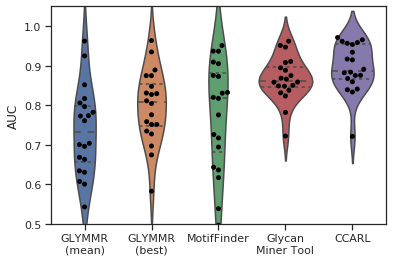

In [137]:
import seaborn as sns
sns.set(style="ticks")
plot_data = np.array([auc_value_mean_glymmr, auc_value_mean_glymmr_best, auc_value_motiffinder, auc_value_means, auc_value_means_ccarl]).T
ax = sns.violinplot(data=plot_data, cut=2, inner='quartile')
sns.swarmplot(data=plot_data, color='black')
ax.set_ylim([0.5, 1.05])
ax.set_xticklabels(["GLYMMR\n(mean)", "GLYMMR\n(best)", "MotifFinder", "Glycan\nMiner Tool", "CCARL"])
#ax.grid('off')
ax.set_ylabel("AUC")
ax.figure.savefig('method_comparison_violin_plot.svg')

In [ ]:
auc_value_means_ccarl

In [125]:
print("CCARL Performance")
print(f"Median AUC value: {np.median(auc_value_means_ccarl): 1.3f}")
print(f"IQR of AUC values: {np.percentile(auc_value_means_ccarl, 25): 1.3f} - {np.percentile(auc_value_means_ccarl, 75): 1.3f}")

CCARL Performance
Median AUC value:  0.887
IQR of AUC values:  0.865 -  0.954


In [127]:
print("Glycan Miner Tool Performance")
print(f"Median AUC value: {np.median(auc_value_means): 1.3f}")
print(f"IQR of AUC values: {np.percentile(auc_value_means, 25): 1.3f} - {np.percentile(auc_value_means, 75): 1.3f}")

Glycan Miner Tool Performance
Median AUC value:  0.862
IQR of AUC values:  0.845 -  0.898


In [128]:
print("Glycan Miner Tool Performance")
print(f"Median AUC value: {np.median(auc_value_mean_glymmr_best): 1.3f}")
print(f"IQR of AUC values: {np.percentile(auc_value_mean_glymmr_best, 25): 1.3f} - {np.percentile(auc_value_mean_glymmr_best, 75): 1.3f}")

Glycan Miner Tool Performance
Median AUC value:  0.807
IQR of AUC values:  0.747 -  0.854


In [129]:
print("Glycan Miner Tool Performance")
print(f"Median AUC value: {np.median(auc_value_mean_glymmr): 1.3f}")
print(f"IQR of AUC values: {np.percentile(auc_value_mean_glymmr, 25): 1.3f} - {np.percentile(auc_value_mean_glymmr, 75): 1.3f}")

Glycan Miner Tool Performance
Median AUC value:  0.732
IQR of AUC values:  0.655 -  0.798


In [267]:
from matplotlib.backends.backend_pdf import PdfPages
sns.reset_orig()
import networkx as nx

for csv_file in csv_files:
    with PdfPages(f"./motif_miner_motifs/glycan_motif_miner_motifs_{csv_file}.pdf") as pdf:
        for motif in motifs[csv_file][0]:
            fig, ax = plt.subplots()
            ccarl.glycan_plotting.draw_glycan_diagram(motif, ax)
            pdf.savefig(fig)
            plt.close(fig)

In [212]:

glymmr_mean_stdev = np.array([0.15108904, 0.08300011, 0.11558078, 0.05259819, 0.061275  ,
       0.09541182, 0.09239553, 0.05114523, 0.05406571, 0.16180131,
       0.10345311, 0.06080207, 0.0479003 , 0.09898648, 0.06137992,
       0.09813596, 0.07010635, 0.14010784, 0.05924527, 0.13165457])

glymmr_best_stdev = np.array([0.08808868, 0.04784959, 0.13252895, 0.03163248, 0.04401516,
       0.08942411, 0.08344247, 0.05714308, 0.05716086, 0.05640053,
       0.08649275, 0.05007289, 0.05452531, 0.05697662, 0.0490626 ,
       0.1264917 , 0.04994508, 0.1030053 , 0.03359648, 0.12479809])

auc_value_std_ccarl = [np.std(auc_values_ccarl[x*5:x*5+5]) for x in range(int(len(auc_values_ccarl) / 5))]
 
print(r"Lectin  & GLYMMR(mean) & GLYMMR(best) & Glycan Miner Tool & MotifFinder & CCARL \\ \hline")
for i, csv_file, name in zip(list(range(len(csv_files))), csv_files, csv_file_normal_names):
    print(f"{name} & {auc_value_mean_glymmr[i]:0.3f} ({glymmr_mean_stdev[i]:0.3f}) & {auc_value_mean_glymmr_best[i]:0.3f} ({glymmr_best_stdev[i]:0.3f}) \
& {np.mean(aucs[csv_file]):0.3f} ({np.std(aucs[csv_file]):0.3f}) & {auc_value_motiffinder[i]:0.3f} & {auc_value_means_ccarl[i]:0.3f} ({auc_value_std_ccarl[i]:0.3f}) \\\\") 

Lectin  & GLYMMR(mean) & GLYMMR(best) & Glycan Miner Tool & MotifFinder & CCARL \\ \hline
\textit{Agaricus bisporus} agglutinin (ABA) & 0.607 (0.151) & 0.776 (0.088) & 0.888 (0.067) & 0.905 & 0.934 (0.034) \\
Concanavalin A (Con A) & 0.760 (0.083) & 0.875 (0.048) & 0.951 (0.042) & 0.937 & 0.971 (0.031) \\
Peanut agglutinin (PNA) & 0.668 (0.116) & 0.751 (0.133) & 0.894 (0.041) & 0.617 & 0.914 (0.048) \\
\textit{Ricinus communis} agglutinin I (RCA I/RCA\textsubscript{120}) & 0.696 (0.053) & 0.751 (0.032) & 0.848 (0.034) & 0.909 & 0.953 (0.026) \\
\textit{Phaseolus vulgaris} erythroagglutinin (PHA-E) & 0.817 (0.061) & 0.875 (0.044) & 0.910 (0.016) & 0.496 & 0.965 (0.021) \\
\textit{Phaseolus vulgaris} leucoagglutinin (PHA-L) & 0.805 (0.095) & 0.829 (0.089) & 0.858 (0.110) & 0.636 & 0.875 (0.132) \\
\textit{Lens culinaris} agglutinin (LCA) & 0.772 (0.092) & 0.811 (0.083) & 0.908 (0.083) & 0.832 & 0.956 (0.037) \\
\textit{Sambucus nigra} agglutinin (SNA) & 0.962 (0.051) & 0.963 (0.057) & 0.